# "Evaluating penalty takers using empirical Bayes estimation"
> "In this post we will use empirical Bayes estimation to create a model to predict penalty conversion rate. We will then take a look at the best and worst penalty takers, investigate Manchester City and Fulham's struggles from spot kicks and use our new estimate to simulate the Euro 96 penalty shootout."

- toc: true
- branch: master
- badges: true
- comments: true
- author: Tom Whelan
- categories: [Bayes, football, visualisation]
- image: images/bayes_man_city.png

# Why do we assume every player is equally skilled from the penalty spot?

Last weekend there were two big penalty misses in the Premier league, one by Kevin De Bruyne against Liverpool and the other by Ademola Lookman against West Ham, both of which cost their respective teams valuable points. It's rare to see two penalties that bad in the same weekend - in fact the last time someone completely missed the target from the spot in the Premier league [also cost Manchester City three points against Liverpool!](https://talksport.com/football/786186/kevin-de-bruyne-penalty-miss-liverpool-premier-league-stat-man-city/) So why was Lookman even taking Fulham's penalty in the first place, and are City so bad at penalties that [Ederson might actually be the best man for the job?](https://www.manchestereveningnews.co.uk/sport/football/football-news/man-city-penalties-ederson-gundogan-17676765)

Trying to [quantify finishing skill](https://statsbomb.com/2017/07/quantifying-finishing-skill/) is not a new idea in the football analytics community, but penalties are usually an afterthought in the analysis (if they are considered at all). I've seen plenty of posts about expected goals (I've even [written some](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)), and the typical process of dealing with penalties is to just throw away the data and assume penalty xG = penalties taken * average conversion rate. I have been guilty of that myself, but are we really saying [Gabriel Jesus](https://www.transfermarkt.com/gabriel-jesus/elfmetertore/spieler/363205) (4/10 penalties scored) is just as good as [Yaya Touré](https://www.transfermarkt.com/yaya-toure/elfmetertore/spieler/13091) (15/15)? Is Touré the same as [Matt Le Tissier](https://www.transfermarkt.com/matt-le-tissier/elfmetertore/spieler/43705) (27/27)? There are plenty of 'best penalty takers of all time' articles that suggest otherwise (1.16 million results on Google). We can do better.

Here are some typical reasons people give for ignoring finishing skill estimates:

1.   On-ball data is noisy and we are missing key information about defender positions, whether the shot with the player's strong or weak foot and countless other variables.
2.   The sample size of shots from any given location is small.
3.   Even if we could find some signal in the noise, there probably isn't much difference between the best finisher and the worst anyway.

Whilst you *might* be able to get away with that line of thinking in general, it seems odd to apply that logic to penalties, since:

1.   The most important concerns aren't a factor here; the main differences between one penalty and another are [goalkeeper skill](https://youtu.be/o3NKSLKTeDM?t=12), [pitch conditions](https://youtu.be/WlEUdZgH0gc?t=193), and (dare I say it!) confidence. We could make this process significantly more complicated by trying to account for those variables, but that might be overthinking things given what we're trying to accomplish. Unlike open-play shots a rocket into the top corner isn't necessarily better than a delicate chip down the middle (unless your name is Ademola Lookman!), so we can focus more on the results than the execution. If a club wanted to use this process to find their best penalty taker ***these variables could be controlled***, for example by having a penalty shootout (pressure/competitive element) at the end of training (same goalkeeper/pitch conditions) to build up a large sample size of penalty shots for each player in the squad, so a simple model could be just as useful in practice as a more complex one.
2.   We still won't have a huge sample size with penalties, but at least the shot location is fixed.
3.   Intuitively we know there is at least *some* difference, so why don't we try to investigate further?

# Empirical Bayes estimation

There are several methods we could use to create a penalty taking skill estimate, but by far the easiest is [*'empirical Bayes estimation'*](https://en.wikipedia.org/wiki/Empirical_Bayes_method).

> Important: This analysis is heavily inspired by David Robinson's excellent post [*'Understanding empirical Bayes estimation (using baseball statistics)'*](http://varianceexplained.org/r/empirical_bayes_baseball/). Since I prefer Python to R I'll be replicating some of the steps he used but I won't be going as in-depth, so I highly suggest reading through his post first if you have time!

As you'll see in a moment we have data on penalties scored and penalties taken for different players, and we want to estimate penalty conversion rate (scored/taken). Robinson has shown that data in this form can be modelled using a beta distribution. [In his words](http://varianceexplained.org/statistics/beta_distribution_and_baseball/):
> "The beta distribution can be understood as representing a probability distribution *of probabilities* - that is, it represents all the possible values of a probability when we don’t know what that probability is."

In our case the probability we are looking to estimate is penalty conversion rate (or 'probability of a succesful penalty'). Of course we could just take the actual rate, but that's not very useful in practice. Say John Smith has scored 3/3 penalties, do we really think he is incapable of missing? It would be preferable to ask 'what is our realistic best estimate of Smith's conversion rate *given the fact* that he has scored 3/3 so far?' This method is known as [*'Bayesian inference'*](https://en.wikipedia.org/wiki/Bayesian_inference); we start with a *prior* estimate of conversion rate (e.g. the league average distribution) and *update* our estimate to reflect the new evidence we have on Smith (3/3 penalties scored).

> Note: I'm not going to spend much time explaining [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), so if you haven't come across it before see [here](https://www.lesswrong.com/posts/XTXWPQSEgoMkAupKt/an-intuitive-explanation-of-bayes-s-theorem) for a primer (or [here](https://betterexplained.com/articles/an-intuitive-and-short-explanation-of-bayes-theorem/) for the short version).

In standard Bayesian inference we usually decide on the prior distribution ahead of time, but we can approximate this method by *estimating the prior distribution from our data* instead (hence '*empirical estimation*'). To obtain our prior we'll follow Robinson's method - fit a beta distribution to the data and use that as a starting point for each player or team's prediction.


## Estimate a prior from the data

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as ss
import altair as alt
from ipywidgets import widgets, interact
from IPython.display import display

sns.set(style='darkgrid', color_codes=True)
sns.set_context('notebook', font_scale=1.05, rc={'lines.linewidth': 2})
pd.options.display.float_format = '{:.2f}'.format

The main dataset we will be using is from FBRef's [Big 5 European Leagues Stats](https://fbref.com/en/comps/Big5/stats/players/Big-5-European-Leagues-Stats) page. Let's load it in now.

> Note: I am ignoring goalkeeper skill for this analysis, but goalkeeper data is also available at [FBRef](https://fbref.com/en/comps/Big5/keepers/players/Big-5-European-Leagues-Stats) if you want to repeat the steps to estimate penalty save percentage instead! If you aren't familiar with Python I wrote an introductory series that you can check out [here](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/).

In [ ]:
df = pd.read_csv('data/big_five_penalties.csv', encoding='utf-8')
df.head()

,name,team,league,season,penalties_scored,penalties_taken
0,Matt Le Tissier,Southampton,England,1992,2,2
1,Dean Saunders,Aston Villa,England,1992,1,2
2,Alan Shearer,Blackburn,England,1992,3,3
3,John Sheridan,Sheffield Weds,England,1992,2,2
4,Andy Sinton,QPR,England,1992,1,2


The dataset contains penalty statistics for players in France, Germany, Italy, Spain and England's top division from the 92/93 season to November 2020. Whilst that sounds like a lot of data, most of the players have only taken a handful of penalties:

In [ ]:
players = df.groupby('name')[['penalties_scored', 'penalties_taken']].sum().reset_index()

def conversion_rate(df):
    df['conversion_rate'] = df['penalties_scored'] / df['penalties_taken']
    return

conversion_rate(players)
players.describe()

,penalties_scored,penalties_taken,conversion_rate
count,2204.00,2204.00,2204.00
mean,3.90,5.02,0.71
std,6.00,7.13,0.34
min,0.00,1.00,0.00
25%,1.00,1.00,0.50
50%,2.00,2.00,0.83
75%,5.00,6.00,1.00
max,91.00,105.00,1.00


This means that over half of the players in the dataset have a conversion rate of 100% or 0%:

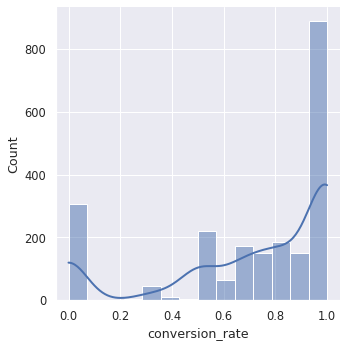

In [ ]:
sns.displot(data=players, x='conversion_rate', kde=True);

Clearly those players would add a lot of noise to our estimate, but we don't want to just throw out a big chunk of data if we can help it. To get around this problem, we can `groupby` 'team' and fit a beta distribution to the resulting team-level data instead. We can then use that prior to get predictions for each player afterwards.

> Note: If you have a better dataset than I do, you could use players to get the prior instead!

In [ ]:
#hide_input
teams = df.groupby('team')[['penalties_scored', 'penalties_taken']].sum().reset_index()
conversion_rate(teams)
teams.describe()

,penalties_scored,penalties_taken,conversion_rate
count,214.00,214.00,214.00
mean,40.21,51.66,0.76
std,35.44,44.60,0.12
min,1.00,1.00,0.20
25%,11.00,15.00,0.73
50%,30.50,39.50,0.77
75%,61.75,79.75,0.83
max,154.00,193.00,1.00


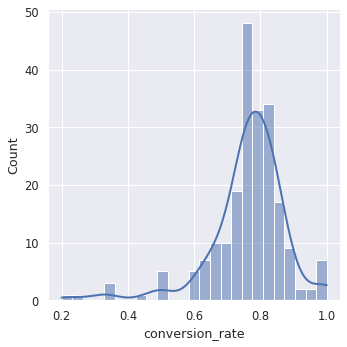

In [ ]:
#hide_input
sns.displot(data=teams, x='conversion_rate', kde=True);

That looks much more reasonable already! Let's filter out teams with fewer than 10 attempts and see what we're left with.

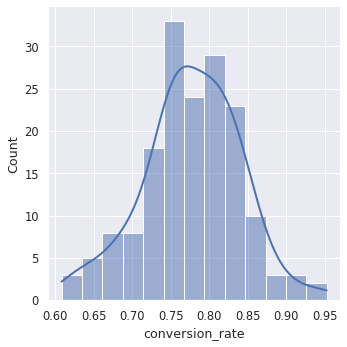

In [ ]:
#hide_input
teams_filt = teams.copy()[teams['penalties_taken']>10]
sns.displot(data=teams_filt, x="conversion_rate", kde=True);

This is what we'd expect to see intuitively; most of the teams are close to the average, with a few teams having performed significantly better or worse than average. Let's try to fit a beta distribution to this data:

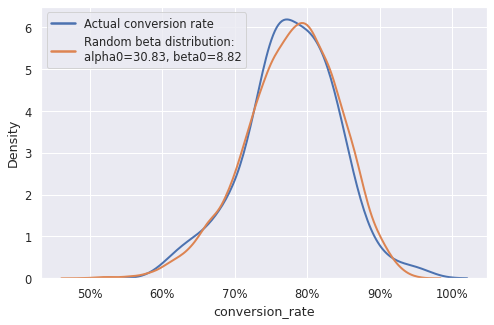

In [ ]:
# Plot the distribution of actual conversion rate (our original data)
palette = sns.color_palette()
fig, ax = plt.subplots(figsize=(8,5))
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
sns.kdeplot(data=teams_filt['conversion_rate'])

# Fit a beta distribution to the data to get the alpha0 and beta0 parameters
# Note that for this to work 0 < data < 1, which is OK in this case, 
# since a predicted conversion rate of 0% or 100% isn't realistic in practice
alpha0, beta0, _, _ = ss.beta.fit(teams_filt['conversion_rate'], floc=0, fscale=1)

# Generate a beta distribution using alpha0 and beta0 (the prior distribution)
prior_dist = ss.beta.rvs(alpha0, beta0, size=10000)

# Plot the random beta distribution we just generated
sns.kdeplot(data=prior_dist)

# Add legend
custom_lines = [Line2D([0], [0], color=palette[0], lw=2.5),
                Line2D([0], [0], color=palette[1], lw=2.5)]
ax.legend(custom_lines, ['Actual conversion rate', 'Random beta distribution:\nalpha0={:.2f}, beta0={:.2f}'.format(alpha0, beta0)]);

That looks good enough for what we are trying to acomplish here! The beta distribution we just generated is defined as:

$X\sim Beta(\alpha_0,\beta_0)$

So what are $\alpha_0$ and $\beta_0$? In this case $\alpha_0$ = penalties scored and $\beta_0$ = penalties missed. With zero evidence we are going to start with the assumption that every player or team has scored $\alpha_0$ times and missed $\beta_0$ times. Our prior estimate of conversion rate is therefore:

$prior\:estimate = \frac{starting\:goals}{starting\:goals\:+\:starting\:misses}  = \frac{\alpha_0}{\alpha_0\:+\:\beta_0}$

We are essentially giving everyone a 'head start' by assuming they have already taken some penalties and converted them at an average rate, which gets around the issue of small sample sizes. To incorporate the additional evidence we have for a particular player or team, we update their distribution as follows:

$Beta(\alpha_0\:+\:goals,\beta_0\:+\:misses)$

Let's take a look at this in action to get a better understanding of the process.

## Visualising the effects of empirical Bayes

Start off with alpha0 = 30.83 goals and beta0 = 8.82 misses:
Prior estimate = 30.83 / (30.83 + 8.82) = 77.76%

Then every time a penalty is taken, add the results to the starting estimate:
New estimate = (alpha0 + penalties_scored) / (alpha0 + beta0 + penalties_taken)



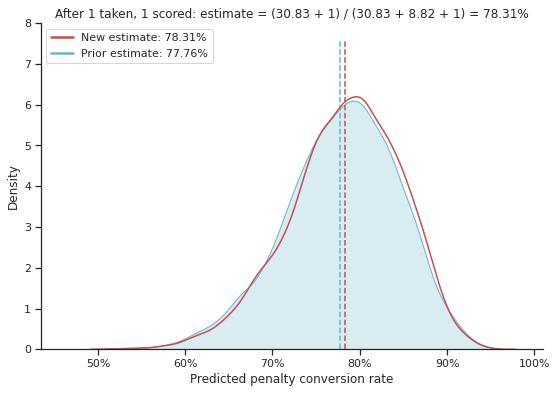

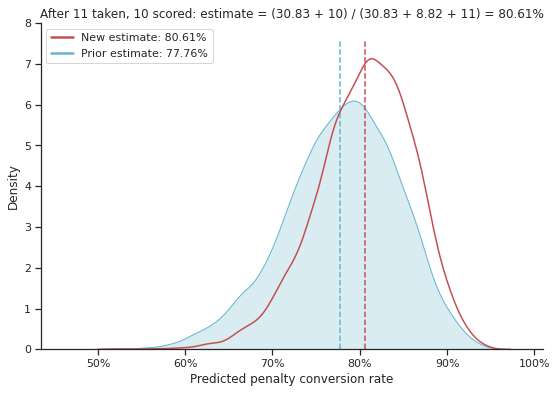

In [ ]:
#collapse-hide
# Define a function to get predicted conversion rate using alpha0 and beta0
def predicted_conversion(scored, taken, alpha=alpha0, beta=beta0):
    return (alpha0 + scored) / (alpha0 + beta0 + taken)

prior = predicted_conversion(scored=0, taken=0)

print('Start off with alpha0 = {:.2f} goals and beta0 = {:.2f} misses:'.format(alpha0, beta0))
print('Prior estimate = {:.2f} / ({:.2f} + {:.2f}) = {:.2%}\n'.format(alpha0, alpha0, beta0, prior))
print('Then every time a penalty is taken, add the results to the starting estimate:')
print('New estimate = (alpha0 + penalties_scored) / (alpha0 + beta0 + penalties_taken)\n')


sns.set(style='ticks')
def plot_dist(scored, missed):
    taken = scored + missed
    new_estimate = predicted_conversion(scored=scored, taken=taken)
    # Plot the prior distribution
    fig, ax = plt.subplots(figsize=(9,6))
    ax.set(title='After {:n} taken, {:n} scored: estimate = ({:.2f} + {:n}) / ({:.2f} + {:.2f} + {:n}) = {:.2%}'.format(taken, scored, alpha0, scored, alpha0, beta0, taken, new_estimate),
        ylim=[0, 8],
        xlabel='Predicted penalty conversion rate')
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
    sns.kdeplot(data=prior_dist, color=palette[-1], fill=True)
    plt.axvline(prior, 0, 0.95, color=palette[-1], linestyle='--')

    # Plot the new distribution
    new_dist = ss.beta.rvs(alpha0+scored, beta0+missed, size=10000)
    sns.kdeplot(data=new_dist, color=palette[3])
    plt.axvline(new_estimate, 0, 0.95, color=palette[3], linestyle='--')

    # Add custom legend and axes
    custom_lines = [Line2D([0], [0], color=palette[3], lw=2.5),
                    Line2D([0], [0], color=palette[-1], lw=2.5)]
    ax.legend(custom_lines,
            ['New estimate: %s' % (str(round(new_estimate*100, 2)))+'%',
            'Prior estimate: %s' % (str(round(prior*100, 2)))+'%'],
            loc='upper left')
    sns.despine(right=True, top=True);

plot_dist(1, 0)
plot_dist(10, 1)

After 1 taken, 1 scored our new estimate is very similar to the prior distribution - we don't want to make drastic changes after just one penalty! After 11 taken, 10 scored the new distribution is taller and narrower, since we are starting to get more confident in our estimate now that we have more information. The new distribution has also shifted to the right, since we think there is a good chance this player is above average. However, even with more evidence this player's predicted conversion rate of 80.61% is still closer to the *average rate* than the his *actual* conversion rate of 90.9%.

The process of pulling estimates back towards the average is sometimes referred to as *'shrinkage'*, which is illustrated more clearly in the interactive chart below. Teams with a small number of attempts are pulled back towards the prior estimate (the horizontal line) significantly, whereas teams with > 150 attempts have a predicted conversion rate close to their actual conversion rate (i.e. close to the diagonal line). In other words, more evidence = less shrinkage, and vice versa.

In [ ]:
#collapse-hide
teams = teams.assign(predicted_conversion=predicted_conversion(teams['penalties_scored'], teams['penalties_taken']))

# Set colour scheme to update automatically for each chart
scheme = 'inferno'
col1 = matplotlib.colors.to_hex(sns.color_palette(scheme)[0])
col2 = matplotlib.colors.to_hex(sns.color_palette(scheme)[-1])

# Create an interactive scatter plot from teams showing predicted and actual conversion rate
selection = alt.selection_single(on='mouseover');
points = alt.Chart(teams).mark_circle(size=50).add_selection(
    selection
    ).encode(
    x=alt.X('conversion_rate', scale=alt.Scale(domain=(0.1, 1.1)), axis=alt.Axis(format='%', title='Actual conversion rate')),
    y=alt.X('predicted_conversion', scale=alt.Scale(domain=(0.685, 0.875)), axis=alt.Axis(format='%', title='Predicted conversion rate')),
    color=alt.condition(selection, 'penalties_taken:Q', alt.value('grey'),
                        legend=alt.Legend(title='Penalties taken'),
                        scale=alt.Scale(scheme=scheme)),
    opacity=alt.condition(selection, alt.value(0.8), alt.value(0.1)),
    tooltip=['team', 'penalties_scored', 'penalties_taken', 
             alt.Tooltip('conversion_rate', format='.2%'),
             alt.Tooltip('predicted_conversion', format='.2%')]
).interactive().properties(
    width=500,
    height=500,
    title='As the number of penalties taken increases, predicted rate approaches actual rate'
)

# Add horizontal line at y = alpha0 / (alpha0 + beta0)
overlayh = pd.DataFrame({'y': [prior]})
hline = alt.Chart(overlayh).mark_rule(color=col1, strokeWidth=2).encode(y='y:Q')
overlayhtext = pd.DataFrame({'x': [0.4], 'y': [prior], 'text': ['Prior: y = alpha0 / (alpha0 + beta0)']})
htext = alt.Chart(overlayhtext).mark_text(color=col1, fontSize=15, baseline='bottom').encode(alt.X('x:Q'), alt.Y('y:Q'), alt.Text('text'))

# Add diagonal line at y = x
overlayd = pd.DataFrame({'x': [-5, 0.7, 5], 'y': [-5, 0.7, 5], 'text': ['', 'y = x', '']})
dline = alt.Chart(overlayd).mark_line(color=col2, strokeWidth=2).encode(x='x:Q', y='y:Q')
dtext = alt.Chart(overlayd).mark_text(color=col2, fontSize=15, angle=285, baseline='top').encode(alt.X('x:Q'), alt.Y('y:Q'), alt.Text('text'))
alt.layer(points, hline, htext, dline, dtext
).configure_header(
    titleFontSize=20,
    titleFontWeight='normal'
).configure_axis(
    labelFontSize=11,
    titleFontSize=14,
    titleFontWeight='normal'
).configure_legend(
    labelFontSize=11,
    titleFontSize=12,
    titleFontWeight='normal'
)

alt.LayerChart(...)

# Who are the best and worst penalty takers?

As we saw earlier, most players in the dataset have only taken a handful of penalties, and some of the players ranked worst in our new metric were players that happened to miss several times in their first few attempts. It might be more interesting to look at players who have taken at least 15 penalties (i.e. a team's main penalty taker for multiple seasons) instead. Let's start with the worst players in the dataset:

In [ ]:
#hide_input
pd.options.display.float_format = '{:.2%}'.format
players = players.assign(predicted_conversion=predicted_conversion(players['penalties_scored'], players['penalties_taken']))
players[players['penalties_taken']>=15].sort_values(by='predicted_conversion').head(10)

,name,penalties_scored,penalties_taken,conversion_rate,predicted_conversion
1330,Marek Hamšík,7,15,46.67%,69.22%
1309,Marco Di Vaio,13,22,59.09%,71.10%
1152,Kevin Phillips,11,18,61.11%,72.56%
125,Andrea Pirlo,14,22,63.64%,72.72%
1771,Roberto Baggio,12,19,63.16%,73.03%
2107,Wayne Rooney,23,34,67.65%,73.09%
501,Diego,13,20,65.00%,73.48%
1163,Klaas-Jan Huntelaar,11,17,64.71%,73.84%
1226,Luca Toni,17,25,68.00%,73.98%
650,Fernando Torres,20,29,68.97%,74.04%


Some surprising names there perhaps! Pirlo consistently pops up on '[best penalty takers'](https://www.sportyghost.com/top-10-best-penalty-takers-in-football-world/) lists,  but even if we look at his overall record on [Transfermarkt](https://www.transfermarkt.com/andrea-pirlo/elfmetertore/spieler/5817) we get a predicted conversion rate of just 74.5%. [Roberto Baggio's](https://www.transfermarkt.com/roberto-baggio/elfmetertore/spieler/4153) career record, on the other hand, is much better than it looks here (83.2%). 

> Note: Transfermarkt's league coverage isn't exhaustive but I'm yet to find a comprehensive resource for penalty stats, so I will be using Transfermarkt's 'career' totals throughout the post in addition to the main FBRef dataset.

What about the best players in the dataset?

In [ ]:
#hide_input
players[players['penalties_taken']>=15].sort_values(by='predicted_conversion', ascending=False).head(10)

,name,penalties_scored,penalties_taken,conversion_rate,predicted_conversion
1599,Olivier Monterrubio,27,27,100.00%,86.77%
1398,Matt Le Tissier,24,24,100.00%,86.15%
1825,Ryad Boudebouz,20,20,100.00%,85.22%
74,Alessandro Del Piero,42,46,91.30%,85.03%
371,Cristhian Stuani,17,17,100.00%,84.43%
609,Fabinho,17,17,100.00%,84.43%
1544,Nenê,22,23,95.65%,84.33%
382,Cristiano Ronaldo,91,105,86.67%,84.23%
544,Eden Hazard,26,28,92.86%,84.01%
1419,Max Kruse,15,15,100.00%,83.86%


It's not surprising to see Le Tissier up there, since he is widely considered to be one of the best penalty takers ever. [Rickie Lambert](https://www.transfermarkt.com/rickie-lambert/elfmetertore/spieler/49655) only took a few penalties in the Premiership, but he is at 87.24% over his career in all competitions. You can investigate different players below; some notable names that weren't in the dataset include goalkeeper [Rogério Ceni](https://www.transfermarkt.com/rogerio-ceni/elfmetertore/spieler/13811) (84.11%), [Michel Platini](https://www.transfermarkt.com/michel-platini/elfmetertore/spieler/88994) (86.36%), [Marco Van Basten](https://www.transfermarkt.com/marco-van-basten/elfmetertore/spieler/74471) (86.46%), [Davor Suker](https://www.transfermarkt.com/davor-suker/elfmetertore/spieler/1407) (88.03%), [Ferenc Puskás](https://www.transfermarkt.com/ferenc-puskas/elfmetertore/spieler/103092) (88.19%), [Ronald Koeman](https://www.transfermarkt.com/ronald-koeman/elfmetertore/spieler/7940) (89.54%) and [Alan Shearer](https://www.transfermarkt.com/alan-shearer/elfmetertore/spieler/3110) (89.86%, more on him later!). The best I've found so far is [Hugo Sánchez](https://www.transfermarkt.com/hugo-sanchez/elfmetertore/spieler/84528), who's 65/65 record puts him at 91.57%!


In [ ]:
#collapse-hide
text = widgets.Text()
display(text)
button = widgets.Button(description='Search')
display(button)

def on_button_clicked(b):
    display(players[players['name'].str.contains(text.value)])

button.on_click(on_button_clicked)

Text(value='')

Button(description='Search', style=ButtonStyle())

,name,penalties_scored,penalties_taken,conversion_rate,predicted_conversion
699,Frank Lampard,43,50,86.00%,82.36%


,name,penalties_scored,penalties_taken,conversion_rate,predicted_conversion
684,Francesco Totti,70,85,82.35%,80.89%


In [ ]:
#collapse-hide
def slider(scored, missed):
    print('Predicted conversion rate = {:.2%}'.format(predicted_conversion(scored, scored + missed)))
interact(slider, scored=widgets.IntSlider(min=0, max=150, step=1, value=65), 
         missed=widgets.IntSlider(min=0, max=150, step=1, value=0));

interactive(children=(IntSlider(value=65, description='scored', max=150), IntSlider(value=0, description='miss…

You might have noticed that this is a rare top ten list without Messi, and in the past he has even been called out for being ['phenomenally bad'](https://www.joe.co.uk/sport/lionel-messis-barcelona-penalty-record-is-phenomenally-bad-16180?cacheTtl=5&cacheKey=request-browser-httpswwwjoecouksportlionel-messis-barcelona-penalty-record-is-phenomenally-bad16180) at penalties. Let's check whether that criticism was warranted.

## Is Lionel Messi 'phenomenally bad' at penalties?
Pretty average, actually.

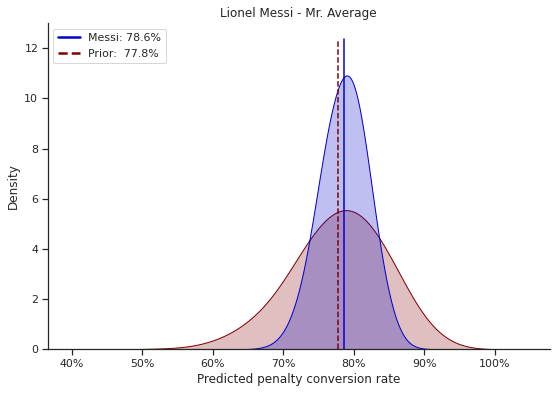

In [ ]:
#collapse-hide
# Initialise the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.set(title='Lionel Messi - Mr. Average',
       ylim=[0, 13],
       xlabel='Predicted penalty conversion rate')
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))

# Generate a beta distribution representing the range of estimates for an average player
sns.kdeplot(data=prior_dist, color='maroon', fill=True, bw_adjust=3)
plt.axvline(prior, 0, 0.95, c='maroon', linestyle='--')

# Generate a beta distribution representing the range of estimates for Messi
# Note - using career numbers from Transfermarkt
# https://www.transfermarkt.com/lionel-messi/elfmetertore/spieler/28003
goals = 97
misses = 26
messi_dist = ss.beta.rvs(alpha0+goals, beta0+misses, size=10000)
sns.kdeplot(data=messi_dist, color='mediumblue', fill=True, bw_adjust=3)
est1 = predicted_conversion(goals, goals+misses)
plt.axvline(est1, 0, 0.95, c='mediumblue')

# Add custom legend and axes
custom_lines = [Line2D([0], [0], color='mediumblue', lw=2.5),
                Line2D([0], [0], color='maroon', lw=2.5, linestyle='--')]
ax.legend(custom_lines,
          ['Messi: %s' % (str(round(est1*100, 1)))+'%',
           'Prior:  %s' % (str(round(prior*100, 1)))+'%'],
          loc='upper left')
sns.despine(right=True, top=True);

The beta distribution for our prior estimate is shown in red, with Messi's beta distribution in blue.

> Tip: Definitely make your charts look worse by using Barcelona colours!

The distribution for Messi is taller and narrower than the prior distribution. This is because we have 123 penalty attempts for Messi whereas our prior distribution starts off with a lot less, so we are more confident in Messi's prediction. We can also see that whilst Messi isn't 'phenomenally bad' at penalties, in this case we may have found something he doesn't excel at.

# Are Manchester City bad at penalties?

In [ ]:
#collapse-hide
# Filter to the start of the 16/17 season
teams_since_16 = df[df['season']>2016].groupby('team')[['penalties_scored', 'penalties_taken']].sum().reset_index()
conversion_rate(teams_since_16)
teams_since_16 = teams_since_16.assign(predicted_conversion=predicted_conversion(teams_since_16['penalties_scored'], teams_since_16['penalties_taken']))

def percentile(all_scores, score):
    return round(ss.stats.percentileofscore(all_scores, score), 1)

city_pct = percentile(teams_since_16['penalties_taken'], teams_since_16.set_index('team').loc['Manchester City', 'penalties_taken'])
print('Manchester City have taken more penalties than '+str(city_pct)+"% of teams in Europe's big five leagues since 16/17. However...")

Manchester City have taken more penalties than 84.5% of teams in Europe's big five leagues since 16/17. However...


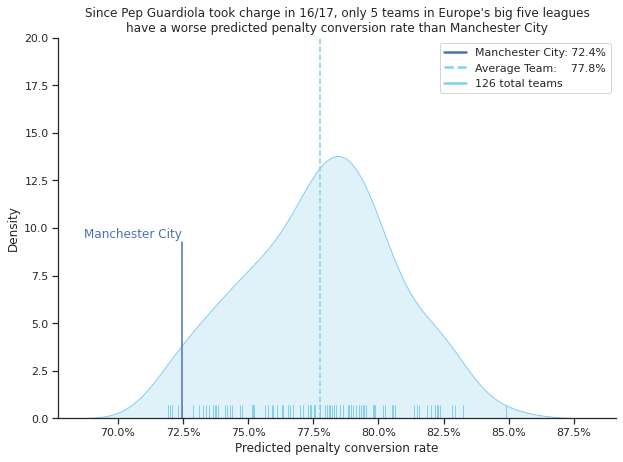

In [ ]:
#collapse-hide
palette = sns.color_palette()
score = teams_since_16.set_index('team').loc['Manchester City', 'predicted_conversion']
worse_or_equal = teams_since_16[teams_since_16['predicted_conversion']<=score]
worse_teams = len(worse_or_equal) - 1

# Create the main plot
fig, ax = plt.subplots(figsize=(10,7))
ax.set(title="Since Pep Guardiola took charge in 16/17, only %d teams in Europe's big five leagues\nhave a worse predicted penalty conversion rate than Manchester City" % (worse_teams),
       ylim=[0, 20],
       xlabel='Predicted penalty conversion rate')
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
sns.kdeplot(data=teams_since_16['predicted_conversion'], color='skyblue', fill=True)
plt.axvline(teams_since_16['predicted_conversion'].mean(), 0, 20, c='skyblue', linestyle='--')
lineheight = 0.65*teams_since_16[teams_since_16['team']=='Manchester City']['penalties_taken'].values[0]/teams_since_16['penalties_taken'].max()
textheight = 20.5*lineheight
plt.axvline(score, 0, lineheight, c=palette[0])
plt.text(score, textheight, 'Manchester City', c=palette[0], ha='right')

# Add rug - https://seaborn.pydata.org/generated/seaborn.rugplot.html#seaborn.rugplot
sns.rugplot(data=teams_since_16['predicted_conversion'], color='skyblue', height=0.035)

# Add legend
custom_lines = [Line2D([0], [0], color=palette[0], lw=2.5),
                Line2D([0], [0], color='skyblue', lw=2.5, linestyle='--'),
                Line2D([0], [0], color='skyblue', lw=2.5)]

ax.legend(custom_lines, 
          ['Manchester City: %s' % (str(round(score*100, 1))+'%'),
           'Average Team:    %s' % (str(round(teams_since_16['predicted_conversion'].mean()*100, 1))+'%'),
           '%d total teams' % (len(teams_since_16))])

# Remove axes
sns.despine(right=True, top=True);

In [ ]:
#hide_input
pd.options.display.float_format = '{:.2%}'.format
worse_or_equal.sort_values('predicted_conversion', ascending=False)

,team,penalties_scored,penalties_taken,conversion_rate,predicted_conversion
73,Manchester City,16,25,64.00%,72.44%
107,Stoke City,0,3,0.00%,72.29%
118,Valladolid,10,17,58.82%,72.08%
5,Atalanta,15,24,62.50%,72.00%
17,Brest,2,6,33.33%,71.92%
87,Nürnberg,2,6,33.33%,71.92%


There's always going to be some variance involved in a stat like that, but there could be other factors at play as well:

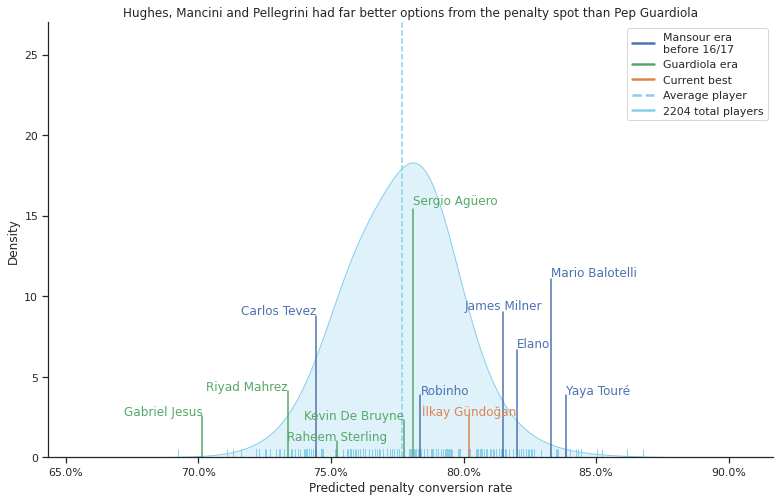

In [ ]:
#collapse-hide
# Data from https://www.transfermarkt.com/manchester-city/elfmeterschuetzen/verein/281
# KDB's estimate includes his miss against Liverpool
man_city_career = {'name': ['Elano', 'Yaya Touré', 'Sergio Agüero', 'Carlos Tevez', 'Robinho', 'Mario Balotelli', 'James Milner',
                            'Raheem Sterling', 'Kevin De Bruyne', 'Gabriel Jesus', 'İlkay Gündoğan', 'Riyad Mahrez'],
                   'penalties_scored': [23,15,47,24,12,38,30,
                                        2,7,4,9,10],
                   'penalties_taken': [26,15,60,34,15,43,35,
                                       4,9,10,10,16],
                   'align': ['left', 'left', 'left', 'right', 'left', 'left', 'center',
                             'center', 'right', 'right', 'center', 'right'],
                   'palette': [0,0,2,0,0,0,0,
                               2,2,2,1,2]}
man_city = pd.DataFrame.from_dict(man_city_career)
man_city = man_city.assign(predicted_conversion=predicted_conversion(man_city['penalties_scored'], man_city['penalties_taken'])).sort_values(by='predicted_conversion', ascending=False)

# Create the main plot
fig, ax = plt.subplots(figsize=(13,8))
ax.set(title='Hughes, Mancini and Pellegrini had far better options from the penalty spot than Pep Guardiola',
       ylim=[0, 27],
       xlabel='Predicted penalty conversion rate')
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
palette = sns.color_palette()
sns.kdeplot(data=players['predicted_conversion'], color='skyblue', fill=True, bw_adjust=3)

# Add mean
plt.axvline(players['predicted_conversion'].mean(), 0, 27, c='skyblue', linestyle='--')

for index, row in man_city.iterrows():
    # Set line height to be proportional to number of penalties taken
    lineheight = row['penalties_taken']/players['penalties_taken'].max()
    textheight = 27.5*lineheight
    plt.axvline(row['predicted_conversion'], 0, lineheight, c=palette[row['palette']])
    plt.text(row['predicted_conversion'], textheight, row['name'], c=palette[row['palette']], ha=row['align'])

# Add rug
sns.rugplot(data=players['predicted_conversion'], color='skyblue', height=0.02)

# Add legend
custom_lines = [Line2D([0], [0], color=palette[0], lw=2.5),
                Line2D([0], [0], color=palette[2], lw=2.5),
                Line2D([0], [0], color=palette[1], lw=2.5),
                Line2D([0], [0], color='skyblue', lw=2.5, linestyle='--'),
                Line2D([0], [0], color='skyblue', lw=2.5),]
ax.legend(custom_lines, ['Mansour era\nbefore 16/17', 'Guardiola era', 'Current best', 'Average player', '%d total players' % (len(players))])

# Remove axes
sns.despine(right=True, top=True);

We can clearly see a big difference here pre/post Pep (with the exception of Carlos Tevez, who mainly took penalties in 09/10 after Elano left). In fact, the wealth of options meant that James Milner was rarely called upon to take penalties for City. Balotelli famously never needs to look at the ball when he takes a penalty - Joe Hart once said that his penalties were [almost impossible to stop](https://www.goal.com/en-us/news/85/england/2012/03/17/2973811/hart-manchester-citys-balotelli-probably-the-best-penalty), which was far greater praise at the time than it would be now (sorry Joe!), and [did a lap of honour](https://www.manchestereveningnews.co.uk/sport/football/football-news/man-city-penalty-stats-gundogan-17614489) when he finally saved one in training. To answer our earlier question, not only is Yaya Touré significantly better than Gabriel Jesus, they are on opposite ends of the scale! Jesus is great at many aspects of the game, but from the penalty spot he's one of the worst players I've seen with a 70.15% predicted conversion rate.



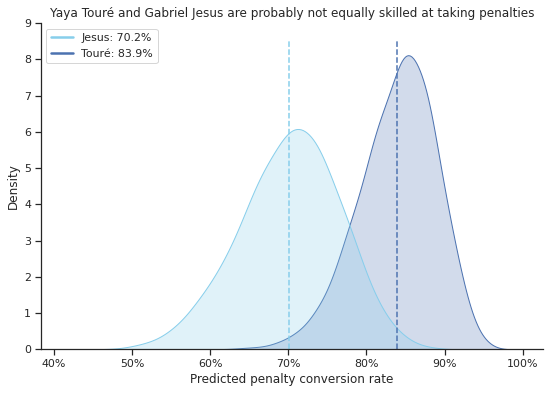

In [ ]:
#collapse-hide
# Plot the range of estimates for Yaya and Jesus
fig, ax = plt.subplots(figsize=(9,6))
ax.set(title='Yaya Touré and Gabriel Jesus are probably not equally skilled at taking penalties',
       ylim=[0, 9],
       xlabel='Predicted penalty conversion rate')
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
# Yaya
goals = 15
misses = 0
yaya_dist = ss.beta.rvs(alpha0+goals, beta0+misses, size=10000)
sns.kdeplot(data=yaya_dist, color=palette[0], fill=True, bw_adjust=1.5)
est1 = predicted_conversion(goals, goals+misses)
plt.axvline(est1, 0, 0.95, c=palette[0], linestyle='--')

# Jesus
goals = 4
misses = 6
jesus_dist = ss.beta.rvs(alpha0+goals, beta0+misses, size=10000)
sns.kdeplot(data=jesus_dist, color='skyblue', fill=True, bw_adjust=1.5)
est2 = predicted_conversion(goals, goals+misses)
plt.axvline(est2, 0, 0.95, c='skyblue', linestyle='--')

# Add custom legend and axes
custom_lines = [Line2D([0], [0], color='skyblue', lw=2.5),
                Line2D([0], [0], color=palette[0], lw=2.5)]
ax.legend(custom_lines,
          ['Jesus: %s' % (str(round(est2*100, 1)))+'%',
           'Touré: %s' % (str(round(est1*100, 1)))+'%'],
          loc='upper left')
sns.despine(right=True, top=True);

Aside from his well publicised disagreements with Touré it's hard to blame Pep too much, since it appears his current squad are good at everything *but* penalties. İlkay Gündoğan's miss came at a time when City had already missed [three of their last five](https://www.thesun.co.uk/sport/football/10875632/man-city-penalty-ilkay-gundogan-pep-guardiola/) so we can certainly speculate that there would have been a lot of pressure to change things; in fact as I alluded to earlier things got so bad that [Pep was seriously considering putting Ederson in charge of spot kicks.](https://www.manchestereveningnews.co.uk/sport/football/football-news/man-city-penalties-ederson-gundogan-17676765) De Bruyne's miss against Liverpool bumped his estimate down to about league average, but he was still predicted to be a bit worse than Gündoğan before that:

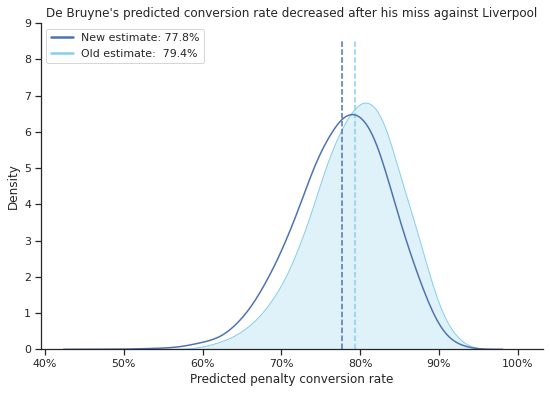

In [ ]:
#collapse-hide
# Plot the range of estimates for KDB before and after his penalty against Liverpool
fig, ax = plt.subplots(figsize=(9,6))
ax.set(title="De Bruyne's predicted conversion rate decreased after his miss against Liverpool",
       ylim=[0, 9],
       xlabel='Predicted penalty conversion rate')
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
# Before Liverpool penalty
goals = 7
misses = 1
kdb_dist = ss.beta.rvs(alpha0+goals, beta0+misses, size=10000)
sns.kdeplot(data=kdb_dist, color='skyblue', fill=True, bw_adjust=1.5)
est1 = predicted_conversion(goals, goals+misses)
plt.axvline(est1, 0, 0.95, c='skyblue', linestyle='--')

# After Liverpool penalty
misses = 2
kdb_dist = ss.beta.rvs(alpha0+goals, beta0+misses, size=10000)
sns.kdeplot(data=kdb_dist, color=palette[0], bw_adjust=1.5)
est2 = predicted_conversion(goals, goals+misses)
plt.axvline(est2, 0, 0.95, c=palette[0], linestyle='--')

# Add custom legend and axes
custom_lines = [Line2D([0], [0], color=palette[0], lw=2.5),
                Line2D([0], [0], color='skyblue', lw=2.5)]
ax.legend(custom_lines,
          ['New estimate: %s' % (str(round(est2*100, 1)))+'%',
           'Old estimate:  %s' % (str(round(est1*100, 1)))+'%'],
          loc='upper left')
sns.despine(right=True, top=True);

In [ ]:
#hide_input
gundo_pct = percentile(players['predicted_conversion'], man_city.set_index('name').loc['İlkay Gündoğan', 'predicted_conversion'])
gundo_rate = str(round(predicted_conversion(9, 10)*100, 2))+'%!'
print('İlkay Gündoğan is at the '+str(gundo_pct)+'th percentile of %d players in the dataset, with a predicted conversion rate of' % (len(players)), gundo_rate)

İlkay Gündoğan is at the 92.2th percentile of 2204 players in the dataset, with a predicted conversion rate of 80.22%!


This analysis suggests Gündoğan deserves another go, and I'd like to see him given the nod the next time he's on the pitch. We aren't talking about a massive difference between the two players, but why not take edges anywhere you can, even if they are small ones? We have to assume Ederson is worse than Gündoğan as well since we have no additional data, but if Ederson really is City's best penalty taker then why not use him - it can't really get much worse at this point!

# Why isn't Aleksandar Mitrović taking penalties for Fulham?

[Antonin Panenka](https://www.transfermarkt.com/antonin-panenka/elfmetertore/spieler/60800) (83.5% predicted conversion rate) might not have been too pleased with the result of Ademola Lookman's botched attempt against West Ham last weekend. Lookman was heavily criticised, and at the time I was wondering why Aleksandar Mitrović wasn't the one taking the penalty. Now I know why:

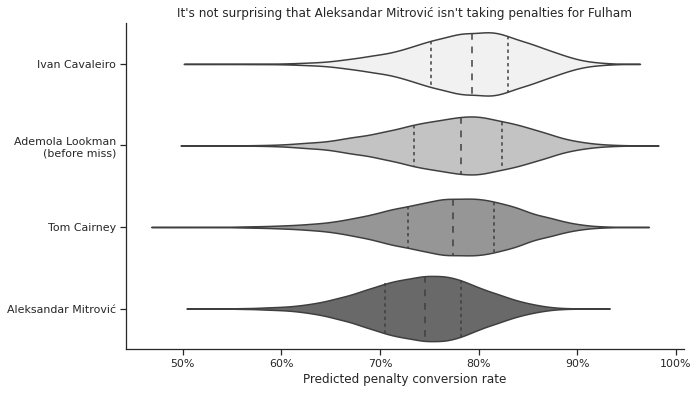

In [ ]:
#collapse-hide
fulham_career = {'name': ['Aleksandar Mitrović', 'Tom Cairney', 'Ivan Cavaleiro', 'Ademola Lookman\n(before miss)'],
                 'penalties_scored': [15,2,6,0],
                 'penalties_taken': [22,3,7,0]}

fulham = pd.DataFrame.from_dict(fulham_career)
fulham = fulham.assign(predicted_conversion=predicted_conversion(fulham['penalties_scored'], fulham['penalties_taken'])).sort_values(by='predicted_conversion', ascending=False)
fulham['penalties_missed'] = fulham['penalties_taken'] - fulham['penalties_scored']

dist_df = pd.DataFrame()
for index, row in fulham.iterrows():
    dist = ss.beta.rvs(alpha0+row['penalties_scored'], beta0+row['penalties_missed'], size=10000)
    temp = pd.DataFrame({'predicted_conversion': dist})
    temp['name'] = row['name']
    dist_df = dist_df.append(temp)

fig, ax = plt.subplots(figsize=(10,6))
ax.set(title="It's not surprising that Aleksandar Mitrović isn't taking penalties for Fulham")
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
sns.violinplot(data=dist_df, x='predicted_conversion', y='name', palette='light:dimgrey', inner='quart', orient='h', ax=ax)
plt.xlabel('Predicted penalty conversion rate')
plt.ylabel('')
sns.despine(right=True, top=True);

# Alternate - faceted kde plot
#g = sns.FacetGrid(dist_df, row='name',
#                 height=1.7, aspect=4,)
#g.map(sns.kdeplot, 'predicted_conversion');

In [ ]:
#hide_input
mitro_pct = percentile(players['predicted_conversion'], fulham.set_index('name').loc['Aleksandar Mitrović', 'predicted_conversion'])
mitro_rate = str(round(predicted_conversion(15, 22)*100, 2))+'%!'
print('Aleksandar Mitrović is at the '+str(mitro_pct)+'th percentile of %d players in the dataset, with a predicted conversion rate of' % (len(players)), mitro_rate)

Aleksandar Mitrović is at the 3.8th percentile of 2204 players in the dataset, with a predicted conversion rate of 74.34%!


It's a good job Mitrović isn't first choice! Cavaleiro appears to be the best candidate by our estimate, but maybe Lookman showed something in training that set him apart from the rest - the Fulham coaches will have seen him take a lot more penalties than we have. Going for a 'Panenka' on your first attempt certainly suggests that you at least rate your own ability from the spot pretty highly, although if we use that logic maybe we should be recommending John Stones as City's go-to option...
> youtube: https://youtu.be/nz3H72j8qyE

# Are England destined to lose to Germany in a semi-final shootout?

At this point it seems inevitable to most England fans that every major tournament will end in a penalty shootout loss to Germany in the semis. 

![](https://i.pinimg.com/originals/3d/c9/c2/3dc9c27a55dccd132c7e545c6da3e473.jpg)

Let's have a look at the Euro 96 shootout and see whether that's the case.

In [ ]:
#collapse-hide
# https://www.transfermarkt.com/spielbericht/index/spielbericht/935928
eng_career = {'name': ['Alan Shearer', 'Teddy Sheringham', 'Steve McManaman', 'Paul Ince', 'David Platt',
                       'Paul Gascoigne', 'Darren Anderton', 'Gareth Southgate', 'Tony Adams', 'Stuart Pearce',
                       'David Seaman', 'Robbie Fowler'],
              'penalties_scored': [65,30,0,0,13,
                                   1,6,0,0,10,
                                   0,32],
              'penalties_taken': [67,33,0,0,15,
                                  1,6,0,0,10,
                                  0,34],
              'notes': [None, None, None, None, None,
                        None, None, None, None, None,
                        None, 'bench, not used']}

ger_career = {'name': ['Stefan Kuntz', 'Mehmet Scholl', 'Andreas Möller', 'Christian Ziege', 'Dieter Eilts',
                       'Stefan Reuter', 'Matthias Sammer', 'Markus Babbel', 'Andreas Köpke', 'Thomas Strunz',
                       'Thomas Häßler', 'Marco Bode', 'Oliver Bierhoff'],
              'penalties_scored': [34,14,9,2,8,
                                   10,0,0,2,4,
                                   26,0,15],
              'penalties_taken': [39,17,13,3,8,
                                  15,0,0,2,5,
                                  28,1,20],
              'notes': [None, "subbed off 77'", None, None, None,
                        None, None, None, None, "subbed on 118'",
                        "subbed on 77'", "subbed on 110'", "bench, not used"]}

england = pd.DataFrame.from_dict(eng_career)
england = england.assign(predicted_conversion=predicted_conversion(england['penalties_scored'], england['penalties_taken'])).sort_values(by='predicted_conversion', ascending=False)

germany = pd.DataFrame.from_dict(ger_career)
germany = germany.assign(predicted_conversion=predicted_conversion(germany['penalties_scored'], germany['penalties_taken'])).sort_values(by='predicted_conversion', ascending=False)

england

,name,penalties_scored,penalties_taken,notes,predicted_conversion
0,Alan Shearer,65,67,None,0.90
11,Robbie Fowler,32,34,"bench, not used",0.85
1,Teddy Sheringham,30,33,None,0.84
9,Stuart Pearce,10,10,None,0.82
6,Darren Anderton,6,6,None,0.81
4,David Platt,13,15,None,0.80
5,Paul Gascoigne,1,1,None,0.78
2,Steve McManaman,0,0,None,0.78
3,Paul Ince,0,0,None,0.78
7,Gareth Southgate,0,0,None,0.78


It looks like England actually had some good penalty takers available, particularly Shearer who has one of the highest predicted conversion rate of all the players we have found so far. Robbie Fowler was still young at the time but it's notable that England didn't choose to bring him on just before the shootout despite having three substitutions remaining, since he was prolific from the spot later in his career.

In [ ]:
#hide_input
germany

,name,penalties_scored,penalties_taken,notes,predicted_conversion
10,Thomas Häßler,26,28,subbed on 77',0.84
0,Stefan Kuntz,34,39,None,0.82
4,Dieter Eilts,8,8,None,0.81
1,Mehmet Scholl,14,17,subbed off 77',0.79
8,Andreas Köpke,2,2,None,0.79
9,Thomas Strunz,4,5,subbed on 118',0.78
6,Matthias Sammer,0,0,None,0.78
7,Markus Babbel,0,0,None,0.78
3,Christian Ziege,2,3,None,0.77
12,Oliver Bierhoff,15,20,"bench, not used",0.77


Germany did make some substitutions however, bringing their best penalty taker Thomas Häßler on in normal time in addition to Marco Bode and Thomas Strunz in extra time. Whilst Bode (a winger) looks worse than average at penalties he was brought on for a centre-back in an attempt to win the game in extra-time, and he wasn't chosen as one of the top six options in the shootout. It's interesting that Thomas Strunz was brought on to take the second penalty in favour of Oliver Bierhoff (who scored twice in the final), since our estimate is that Bierhoff is below average from the spot. Maybe the coaches were onto something... Captain Andreas Möller scored the winning penalty in sudden-death, but it looks like he was probably a below average penalty taker also.

> Note: Just a reminder that I'm still ignoring goalkeeper skill, but [Andreas Köpke saved 22/84 penalties in his career](https://www.transfermarkt.com/andreas-kopke/elfmeterstatistik/spieler/1445), so maybe it's harder to score against him than a typical goalie!

In [ ]:
#collapse-hide
# Remove unwanted players
fowler = england.copy()[england['name']=='Robbie Fowler']
england = england.copy()[england['name']!='Robbie Fowler']
germany = germany.copy()[~germany['name'].isin(['Mehmet Scholl', 'Oliver Bierhoff'])]

# Order the players to get Platt taking the second penalty etc
# We only know the first six players for each team, so assume the order for the rest
england['order'] = [1,5,3,7,2,4,8,9,6,10,11]
england = england.copy().sort_values('order')
germany['order'] = [1,5,7,8,2,9,10,4,11,6,3]
germany = germany.copy().sort_values('order')

We can see which team is expected to win the shootout by simulating it using the predicted conversion rates for each player to determine whether they scored or missed their penalty. Here is one simulation:

In [ ]:
#collapse-hide
def shootout(team_a, team_b, printer=False):
    """Function to simulate a penalty shootout. Takes two dataframes as input, one for each team.
    The dataframe should be sorted in the order used for the shootout, i.e. the
    first player to take a penalty should be at row 1, the second at row 2 etc.
    """ 
    a_score = 0
    b_score = 0
    a_wins = 0
    b_wins = 0
    a_index = 0
    b_index = 0

    # df index should be from 0 to len(df)
    team_a = team_a.reset_index().drop('index', axis=1)
    team_b = team_b.reset_index().drop('index', axis=1)

    while a_wins == b_wins:
        # Reset index to 0 if every player has taken a penalty in this round
        if a_index > len(team_a)-1:
            a_index = 0
        if b_index > len(team_b)-1:
            b_index = 0

        # Get Team A result
        a_player = team_a.iloc[a_index, 0]
        a_prob = team_a.iloc[a_index, 4]
        a_result = np.random.choice([0,1], 1, p=[1-a_prob, a_prob])
        a_score += a_result
        if printer != False:
            print(a_player+'...scores! (%d-%d)' % (a_score, b_score) if a_result ==1 else a_player+'...misses! (%d-%d)' % (a_score, b_score))

        # Get Team B result
        b_player = team_b.iloc[a_index, 0]
        b_prob = team_b.iloc[a_index, 4]
        b_result = np.random.choice([0,1], 1, p=[1-a_prob, a_prob])
        b_score += b_result
        if printer != False:
            print(b_player+'...scores! (%d-%d)' % (a_score, b_score) if b_result ==1 else b_player+'...misses! (%d-%d)' % (a_score, b_score))
        a_index += 1
        b_index += 1

        # Stop the shootout when scores are no longer equal and at least five penalties each have been taken
        if (a_index >= 5):
            if (a_score > b_score):
                a_wins += 1
                if printer != False:
                    print('\nTeam A wins (%d-%d)' % (a_score, b_score))
            elif (a_score < b_score):
                b_wins += 1
                if printer != False:
                    print('\nTeam B wins (%d-%d)' % (b_score, a_score))

    return a_wins, b_wins

# Run one penalty shootout
_, _ = shootout(england, germany, printer=True)

Alan Shearer...scores! (1-0)
Thomas Häßler...scores! (1-1)
David Platt...scores! (2-1)
Thomas Strunz...scores! (2-2)
Stuart Pearce...scores! (3-2)
Stefan Reuter...scores! (3-3)
Paul Gascoigne...scores! (4-3)
Christian Ziege...scores! (4-4)
Teddy Sheringham...scores! (5-4)
Stefan Kuntz...scores! (5-5)
Gareth Southgate...scores! (6-5)
Andreas Möller...scores! (6-6)
Darren Anderton...scores! (7-6)
Dieter Eilts...scores! (7-7)
Steve McManaman...scores! (8-7)
Andreas Köpke...misses! (8-7)

Team A wins (8-7)


Let's run this thousands of times and calculate how often England would be expected to advance to the final:

In [ ]:
#collapse-hide
num_sims = 5000

def simulate_shootouts(team_a, team_b, num_sims):
    a_wins = 0
    b_wins = 0
    for i in range(num_sims):
        a, b = shootout(team_a, team_b)
        a_wins += a
        b_wins += b
    return a_wins, b_wins

eng_wins, ger_wins = simulate_shootouts(england, germany, num_sims)
eng_win_pct = str(round((eng_wins/num_sims)*100, 1))
print('England win probability = %s' % (eng_win_pct+'%'))

England win probability = 50.6%


Doesn't look like a forgone conclusion! Unless you believe in curses, that is...

# Conclusion
Thanks for reading! I hope you enjoyed this and learned something useful. We could have made a much more complicated model of penalty taking skill, but as discussed earlier extra complexity wouldn't necessarily be better here. By using empirical Bayes estimation we were able to get some interesting insights out of a limited dataset in just a few steps. If you want to explore this topic further you could use the same process to estimate penalty save percentage, or you could try to improve on this model. A couple of ways to do that would be to [use more data](https://fbref.com/en/about/coverage) or estimate different priors for different groups of players, e.g. should the prior distribution for a team's main penalty taker be the same as the prior for someone who was only trusted to take a handful of penalties in their career?

Thanks again to David Robinson, whose work make this possible, and to FBRef and Transfermarkt for the data.